In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

2024-05-07 16:35:45.880944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 16:35:45.881062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 16:35:46.009715: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Training_Input/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1_Training_GroundTruth/*.png'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [4]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

In [5]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_train_ph2_resized.append(resize(filelist_trainx[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy[i]))

In [6]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

In [7]:
filelist_trainx = sorted(glob.glob('/kaggle/input/isic2018/ISIC2018/ISIC2018_Task1-2_Test_Input/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('//kaggle/input/another/another/ISIC2018_Task1_Test_GroundTruth/*.png'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [8]:
X_test_ph2_resized = []
Y_test_ph2_resized = []

for i in range(len(filelist_trainx)):
    X_test_ph2_resized.append(resize(filelist_trainx[i]))
    Y_test_ph2_resized.append(resize(filelist_trainy[i]))

In [9]:
X_test_ph2 = np.array([np.array(img) for img in X_test_ph2_resized])
Y_test_ph2 = np.array([np.array(img) for img in Y_test_ph2_resized])

In [10]:
print("Size of X_train:", X_test.shape)
print("Size of Y_train:", Y_test.shape)

Size of X_train: (1000, 224, 224, 3)
Size of Y_train: (1000, 224, 224)


In [11]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [13]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [14]:
def dice_coef(y_true, y_pred, smooth = 100):
     
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, dtype='float32')
    y_pred_f = K.cast(y_pred_f, dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [16]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [17]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [18]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [19]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [20]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(X_train_ph2, Y_train_ph2)

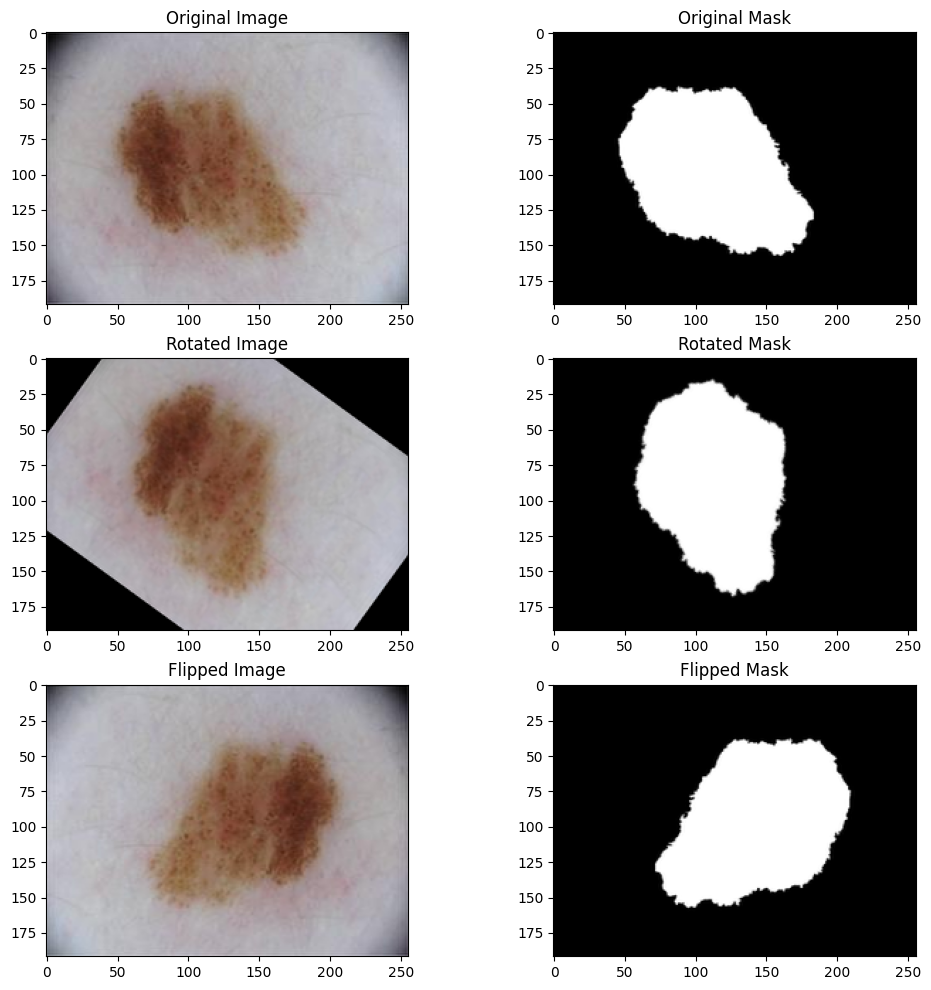

In [21]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(X_train_ph2[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(Y_train_ph2[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [22]:
x_train_full = np.concatenate([X_train_ph2, x_rotated, x_flipped])
y_train_full = np.concatenate([Y_train_ph2, y_rotated, y_flipped])

In [23]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [24]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(X_test_ph2)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 6225
Length of the Test Set       : 1000
Length of the Validation Set : 1557


In [25]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [26]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 192, 256))
        axis = 1
    else:
        inputs = Input((192, 256, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((192, 256))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save('/kaggle/working/' + savename)
    return model, hist

In [27]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 192, 256))
    axis = 1
else:
    inputs = Input((192, 256, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((192, 256))(conv_final)

In [28]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [29]:
model_unet = Model(inputs, pred, name="UNET_224")
model_unet.compile(optimizer=Adam(learning_rate=0.003),
                  loss=[jaccard_distance],
                  metrics=[iou, dice_coef,precision, recall, accuracy])

In [30]:
model_unet.load_weights('/kaggle/input/isic2018-unet/tensorflow2/unet-50/1/unet_50_epoch.keras')

In [31]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [32]:
from tensorflow.keras.optimizers import SGD
model_segnet = Model(inputs=img_input, outputs=pred)

model_segnet.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [33]:
model_segnet.load_weights('/kaggle/input/segnet-isic2018/segnet_isic2018_50.keras')

In [34]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res_unet = model_unet.evaluate(x_train, y_train, batch_size= 18)
res_segnet = model_segnet.evaluate(x_train, y_train, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res_unet = model_unet.evaluate(X_test_ph2, Y_test_ph2, batch_size= 18)
res_segnet = model_segnet.evaluate(X_test_ph2, Y_test_ph2, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res_unet = model_unet.evaluate(x_val, y_val, batch_size= 18)
res_segnet = model_segnet.evaluate(x_val, y_val, batch_size= 18)
print('_______________SegNet_____Unet____')
print('IOU:       |   {:.2f}  |   {:.2f}  |'.format(res_segnet[1]*100, res_unet[1] * 100))
print('Dice Coef: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[2]*100, res_unet[2] * 100))
print('Precision: |   {:.2f}  |   {:.2f}  |'.format(res_segnet[3]*100, res_unet[3] * 100))
print('Recall:    |   {:.2f}  |   {:.2f}  |'.format(res_segnet[4]*100, res_unet[4] * 100))
print('Accuracy:  |   {:.2f}  |   {:.2f}  |'.format(res_segnet[5]*100, res_unet[5] * 100))
print("Loss:      |   {:.2f}  |   {:.2f}  |".format(res_segnet[0]/100, res_unet[0] * 100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------



2024-05-07 16:39:56.965817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.04573, expected 1.27425
2024-05-07 16:39:56.965888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 3.96658, expected 3.19511
2024-05-07 16:39:56.965898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 4.09656, expected 3.32508
2024-05-07 16:39:56.965906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 4.6597, expected 3.88822
2024-05-07 16:39:56.965920: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 4.37681, expected 3.60534
2024-05-07 16:39:56.965927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 3.55211, expected 2.78063
2024-05-07 16:39:56.965935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 4.51545, expected 3.74397
2024-05-07 16:39:56.965942: 

  3/346 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - accuracy: 0.6808 - dice_coef: 1.3780 - iou: 0.3754 - loss: 0.6246 - precision: 0.8902 - recall: 0.7567  

I0000 00:00:1715100006.277286     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7271 - dice_coef: 1.2661 - iou: 0.4364 - loss: 0.5636 - precision: 0.9009 - recall: 0.7046

2024-05-07 16:40:24.939359: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.79377, expected 2.03962
2024-05-07 16:40:24.939432: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 4.69459, expected 3.94044
2024-05-07 16:40:24.939442: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 4.5197, expected 3.76555
2024-05-07 16:40:24.939450: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 5.6043, expected 4.85015
2024-05-07 16:40:24.939457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 4.68178, expected 3.92763
2024-05-07 16:40:24.939465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 4.69357, expected 3.93942
2024-05-07 16:40:24.939472: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 5.40279, expected 4.64864
2024-05-07 16:40:24.939480: E

346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.7271 - dice_coef: 1.2661 - iou: 0.4365 - loss: 0.5635 - precision: 0.9009 - recall: 0.7046


2024-05-07 16:40:43.758576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.23176, expected 1.27425
2024-05-07 16:40:43.758646: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 4.15262, expected 3.19511
2024-05-07 16:40:43.758659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 4.28259, expected 3.32508
2024-05-07 16:40:43.758670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 4.84574, expected 3.88822
2024-05-07 16:40:43.758684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 4.56285, expected 3.60534
2024-05-07 16:40:43.758702: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 3.73815, expected 2.78063
2024-05-07 16:40:43.758715: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 4.70149, expected 3.74397
2024-05-07 16:40:43.758727:

345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7479 - dice_coef: 1.8701 - iou: 0.3985 - loss: -357.5464 - precision: 0.9993 - recall: 0.9866

2024-05-07 16:41:27.531416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.2972, expected 1.35512
2024-05-07 16:41:27.531485: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.29035, expected 2.34827
2024-05-07 16:41:27.531495: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.25674, expected 3.31466
2024-05-07 16:41:27.531502: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.35661, expected 2.41453
2024-05-07 16:41:27.531510: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.61109, expected 2.66901
2024-05-07 16:41:27.531517: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.35577, expected 2.41369
2024-05-07 16:41:27.531525: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.76801, expected 2.82593
2024-05-07 16:41:27.531532: E external/local_xla/xla/ser

346/346 ━━━━━━━━━━━━━━━━━━━━ 57s 121ms/step - accuracy: 0.7479 - dice_coef: 1.8702 - iou: 0.3985 - loss: -357.5343 - precision: 0.9993 - recall: 0.9866
_______________SegNet_____Unet____
IOU:       |   40.26  |   44.08  |
Dice Coef: |   187.37  |   126.79  |
Precision: |   99.96  |   90.18  |
Recall:    |   98.64  |   70.58  |
Accuracy:  |   82.06  |   81.98  |
Loss:      |   -3.55  |   55.92  |
________________________

-------------On Test  Set--------------------------

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6552 - dice_coef: 1.2196 - iou: 0.3621 - loss: 0.6379 - precision: 0.8539 - recall: 0.6658

2024-05-07 16:41:44.258345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98304: 2.18488, expected 1.80195
2024-05-07 16:41:44.258411: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 98334: 2.53651, expected 2.15357
2024-05-07 16:41:44.258458: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 105727: 2.82194, expected 2.439
2024-05-07 16:41:44.258729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147349: 2.59531, expected 2.21238
2024-05-07 16:41:44.258761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147413: 2.55772, expected 2.17478
2024-05-07 16:41:44.258776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147456: 2.81999, expected 1.95352
2024-05-07 16:41:44.258792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147457: 4.54064, expected 3.67417
2024-05-07 16:41:44.2588

56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.6552 - dice_coef: 1.2167 - iou: 0.3620 - loss: 0.6380 - precision: 0.8543 - recall: 0.6643
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6768 - dice_coef: 1.8551 - iou: 0.3290 - loss: -443.3999 - precision: 0.9746 - recall: 0.9936

2024-05-07 16:41:59.843478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.0438, expected 1.60106
2024-05-07 16:41:59.843540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.22923, expected 2.78649
2024-05-07 16:41:59.843556: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 2.9035, expected 2.46076
2024-05-07 16:41:59.843573: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 2.5007, expected 2.05796
2024-05-07 16:41:59.843589: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 3.06632, expected 2.62358
2024-05-07 16:41:59.843601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 2.11991, expected 1.67717
2024-05-07 16:41:59.843612: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 33: 2.69293, expected 2.25019
2024-05-07 16:41:59.843623: E external/local_xla/xla/

56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.6765 - dice_coef: 1.8528 - iou: 0.3289 - loss: -442.6436 - precision: 0.9760 - recall: 0.9936
_______________SegNet_____Unet____
IOU:       |   32.67  |   36.00  |
Dice Coef: |   178.84  |   113.60  |
Precision: |   101.36  |   86.71  |
Recall:    |   99.39  |   62.47  |
Accuracy:  |   78.84  |   77.33  |
Loss:      |   -4.22  |   64.00  |
________________________

-------------On validation Set---------------------

86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7477 - dice_coef: 1.2380 - iou: 0.4684 - loss: 0.5316 - precision: 0.8897 - recall: 0.6925

2024-05-07 16:42:14.424011: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.39683, expected 1.67213
2024-05-07 16:42:14.424072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.42888, expected 3.70417
2024-05-07 16:42:14.424081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.86922, expected 4.14452
2024-05-07 16:42:14.424089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.5663, expected 3.8416
2024-05-07 16:42:14.424097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.89265, expected 4.16794
2024-05-07 16:42:14.424104: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.87448, expected 4.14978
2024-05-07 16:42:14.424112: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.40595, expected 3.68125
2024-05-07 16:42:14.424119: E external/local_xla/xla/serv

87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.7474 - dice_coef: 1.2383 - iou: 0.4680 - loss: 0.5320 - precision: 0.8897 - recall: 0.6926
86/87 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7715 - dice_coef: 1.8665 - iou: 0.4304 - loss: -325.5762 - precision: 1.0175 - recall: 0.9861

2024-05-07 16:42:30.392464: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147456: 1.8998, expected 1.45224
2024-05-07 16:42:30.392530: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147486: 2.46702, expected 2.01946
2024-05-07 16:42:30.392547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147487: 3.06226, expected 2.6147
2024-05-07 16:42:30.392563: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147488: 2.18521, expected 1.73766
2024-05-07 16:42:30.392582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147489: 3.29987, expected 2.85231
2024-05-07 16:42:30.392596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147499: 3.23709, expected 2.78953
2024-05-07 16:42:30.392608: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147506: 3.38023, expected 2.93267
2024-05-07 16:42:30.39

87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.7712 - dice_coef: 1.8665 - iou: 0.4300 - loss: -326.0125 - precision: 1.0172 - recall: 0.9861
_______________SegNet_____Unet____
IOU:       |   41.25  |   45.04  |
Dice Coef: |   186.53  |   124.78  |
Precision: |   100.78  |   89.26  |
Recall:    |   98.65  |   69.53  |
Accuracy:  |   80.65  |   78.44  |
Loss:      |   -3.45  |   54.96  |
________________________


W0000 00:00:1715100156.981501     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2024-05-07 16:43:02.330847: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.58584, expected 1.70188
2024-05-07 16:43:02.330912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.93284, expected 3.04888
2024-05-07 16:43:02.330922: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.44589, expected 3.56193
2024-05-07 16:43:02.330930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.31928, expected 3.43532
2024-05-07 16:43:02.330938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.79514, expected 3.91118
2024-05-07 16:43:02.330948: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.8439, expected 3.95994
2024-05-07 16:43:02.330956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.11976, expected 3.2358
2024-05-07 16:43:02.330964: E external/local_xla/xla/serv

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2024-05-07 16:43:06.192728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.05168, expected 1.70188
2024-05-07 16:43:06.192785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 2.40361, expected 2.0538
2024-05-07 16:43:06.192794: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 2.11563, expected 1.76583
2024-05-07 16:43:06.193087: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.46238, expected 1.95727
2024-05-07 16:43:06.193113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49181: 3.81506, expected 3.30995
2024-05-07 16:43:06.193126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49182: 3.59659, expected 3.09148
2024-05-07 16:43:06.193151: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49183: 3.68422, expected 3.17911
2024-05-07 16:43:06.193162: E external

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


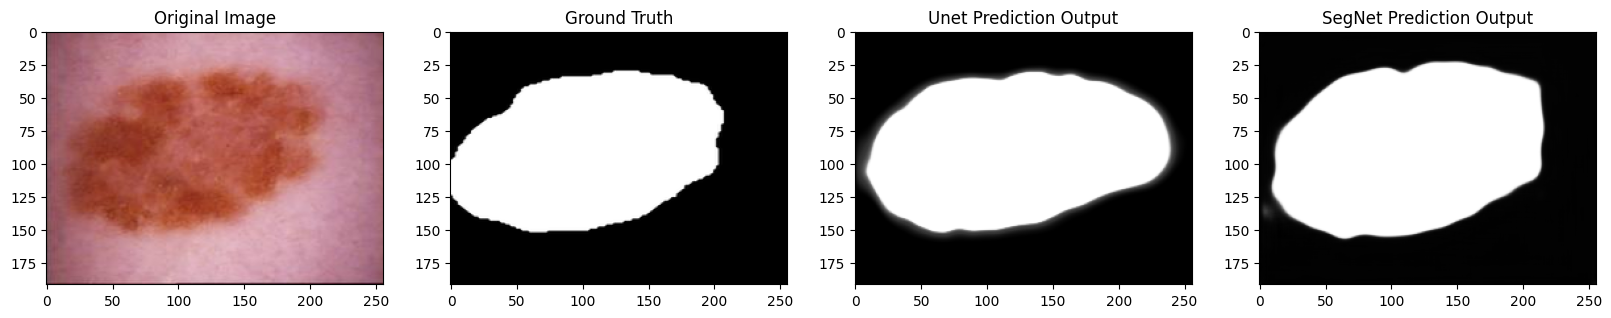

In [35]:
img_num = 408
img_pred1 = model_unet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
plt.figure(figsize=(20,16))
plt.subplot(1,4,1)
plt.imshow(X_test_ph2[img_num])
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(Y_test_ph2[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,4,3)
plt.imshow(img_pred1.reshape(192, 256), plt.cm.binary_r)
plt.title('Unet Prediction Output')
plt.subplot(1,4,4)
plt.imshow(img_pred2.reshape(192, 256), plt.cm.binary_r)
plt.title('SegNet Prediction Output')
plt.show()

In [36]:
def enhance(img):
    sub1 = (model_unet.predict(img.reshape(1,192,256,3))).flatten()
    sub2 = (model_segnet.predict(img.reshape(1,192,256,3))).flatten()
    sub = sub1[:]
    for i in range(len(sub)):
        sub[i] = (sub1[i] + sub2[i])/2

        if sub[i] > 0.7:
            sub[i] = 1
        else:
            sub[i] = 0

    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


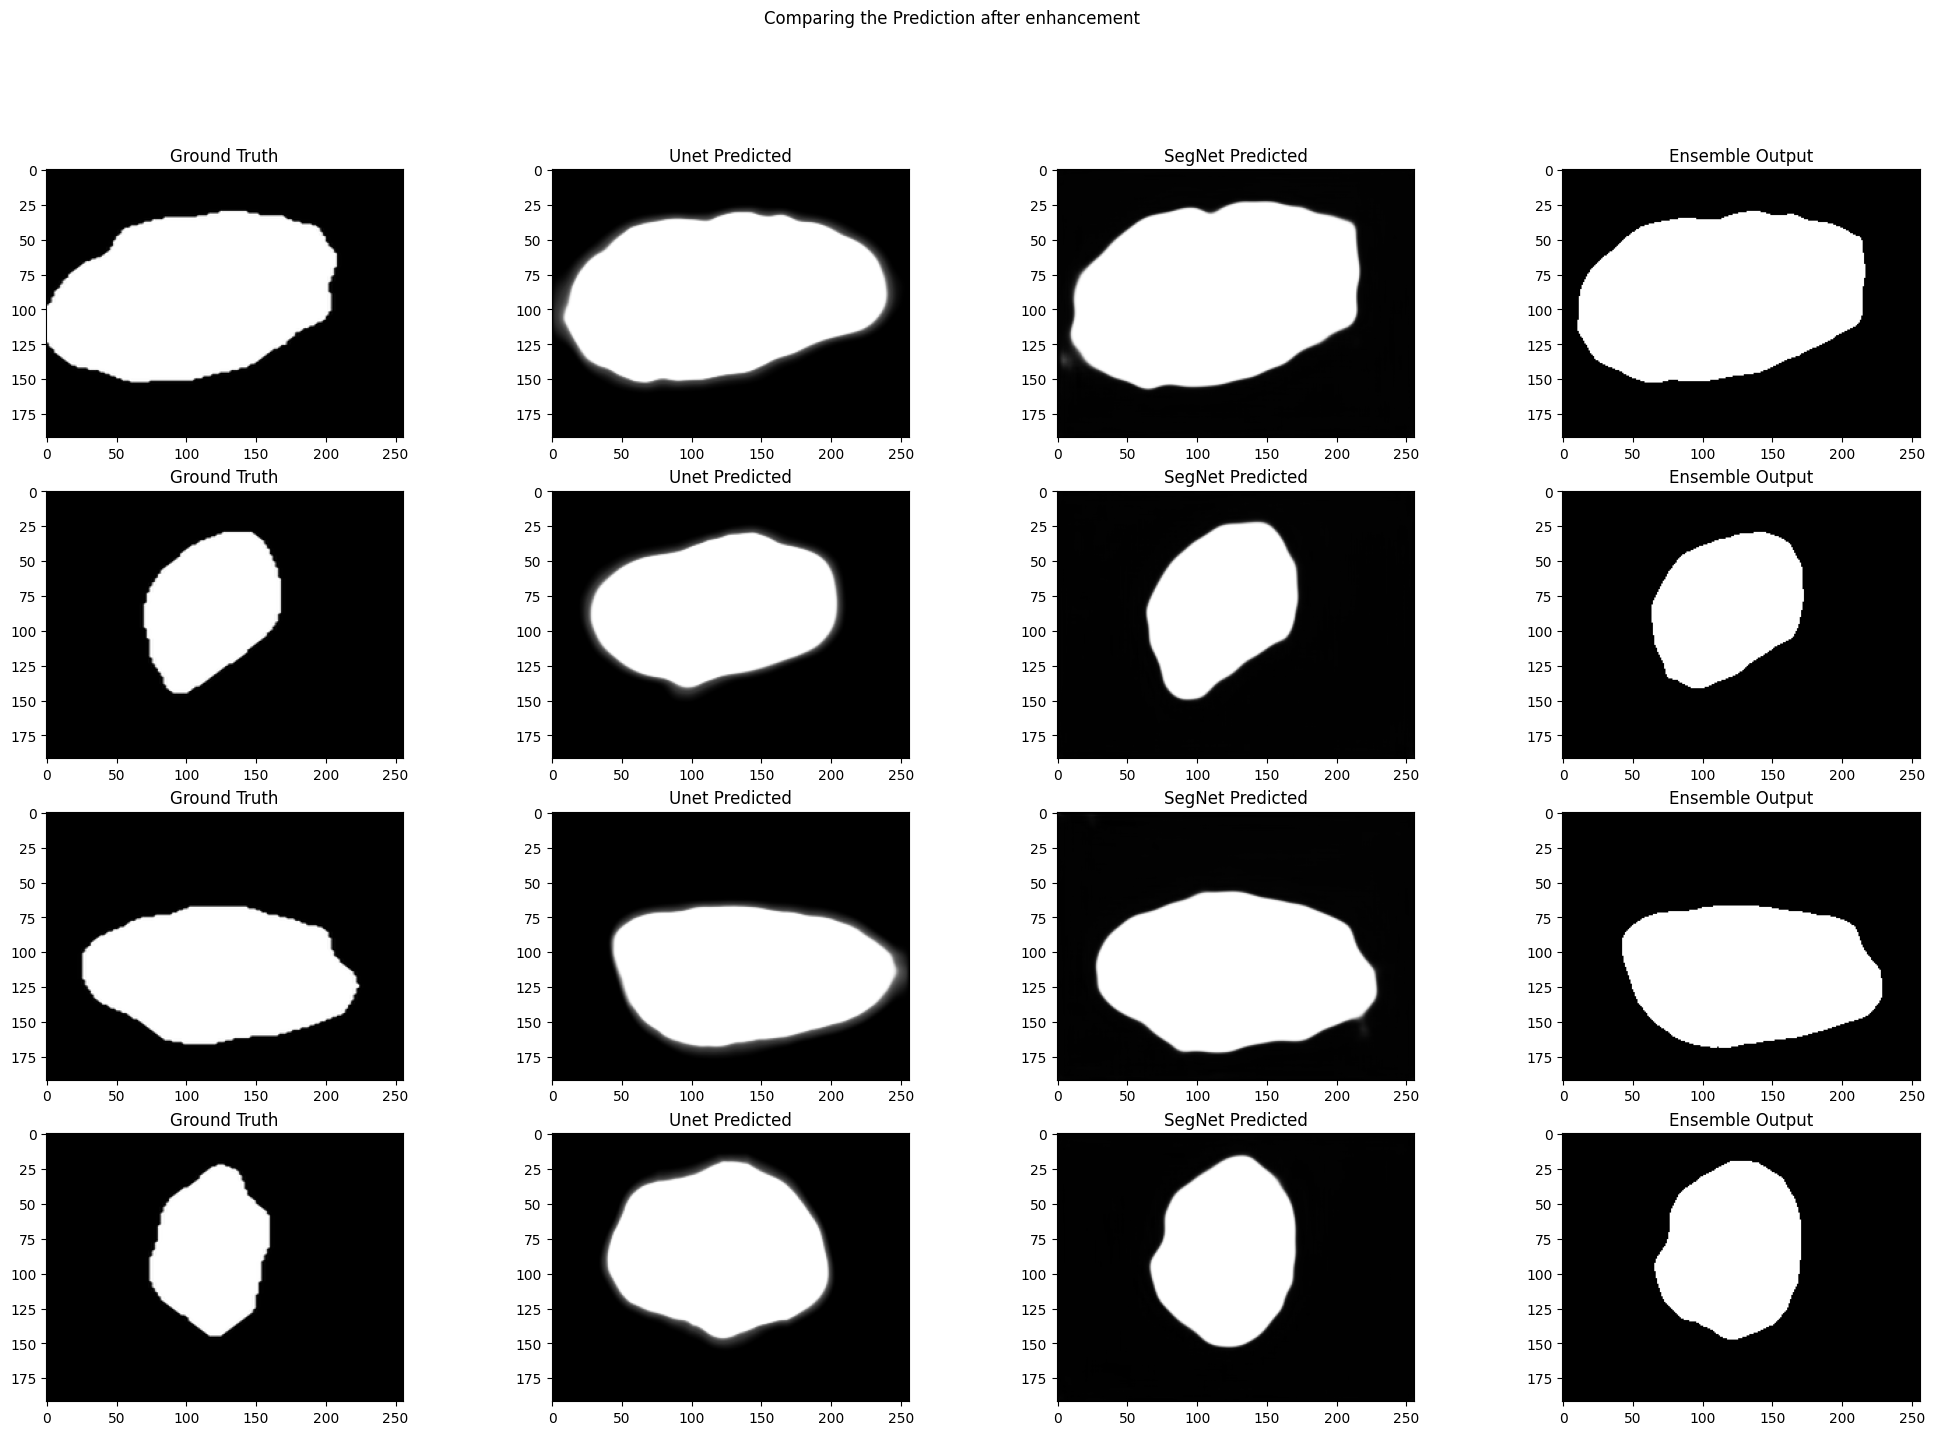

In [37]:
plt.figure(figsize=(25,16))
plt.suptitle('Comparing the Prediction after enhancement')

img_num = 408
plt.subplot(4,4,1)
plt.imshow(Y_test_ph2[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,2)

img_pred1 = model_unet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(X_test_ph2[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,3)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,4)
plt.imshow(enhance(X_test_ph2[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')


img_num = 210
plt.subplot(4,4,5)
plt.imshow(Y_test_ph2[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,6)

img_pred1 = model_unet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(X_test_ph2[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,7)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,8)
plt.imshow(enhance(X_test_ph2[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 324
plt.subplot(4,4,9)
plt.imshow(Y_test_ph2[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,10)

img_pred1 = model_unet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(X_test_ph2[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,11)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,12)
plt.imshow(enhance(X_test_ph2[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')

img_num = 914
plt.subplot(4,4,13)
plt.imshow(Y_test_ph2[img_num],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(4,4,14)

img_pred1 = model_unet.predict(X_test_ph2[img_num].reshape(1,192,256,3))
img_pred2 = model_segnet.predict(X_test_ph2[img_num].reshape(1,192,256,3))

plt.imshow(img_pred1.reshape(192,256), plt.cm.binary_r)
plt.title('Unet Predicted')
plt.subplot(4,4,15)
plt.imshow(img_pred2.reshape(192,256), plt.cm.binary_r)
plt.title('SegNet Predicted')
plt.subplot(4,4,16)
plt.imshow(enhance(X_test_ph2[img_num]).reshape(192,256), plt.cm.binary_r)
plt.title('Ensemble Output')
plt.show()